In [94]:
import random
from collections import defaultdict

import gym
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import Generator
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from envs.robots.robot_arm import RobotArm
from supervised.data import \
    TargetGaussianDataset as SupervisedTargetGaussianDataset
from supervised.loss import PointDistanceLoss
from supervised.utils import forward_kinematics
from vae.data.load_data_set import TargetGaussianDataset

In [30]:
df_start = pd.read_csv("datasets/2/train/state_IK_random_start.csv")
df_action = pd.read_csv("datasets/2/train/actions_IK_random_start.csv")

In [31]:
class WrapperDataset(Dataset):
    def __init__(self, path, supervised=True) -> None:
        if not supervised:
            self.data = TargetGaussianDataset(path, 0.2)
        else:
            self.data = SupervisedTargetGaussianDataset(path, 0.2)
        self.supervised = supervised

    def __getitem__(self, idx):
        if self.supervised:
            x, y = self.data[idx]
            x = x.detach()
            return x, y

        x, cond_enc, cond_dec, y = self.data[idx]
        x = torch.cat([x, cond_enc.detach()])
        # x: delta to target, curr pos, curr angles
        return x, y
    
    def __len__(self):
        return len(self.data)
    

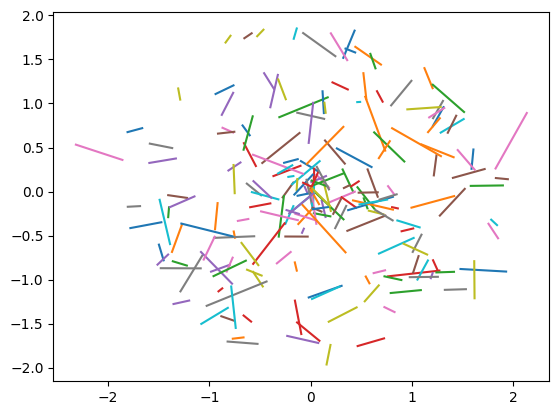

In [32]:
dataset = WrapperDataset("datasets/2/train/state_IK_random_start.csv")

for x, y in random.choices(dataset, k=200):
    curr_pos = x[2: 4]
    target_pos = y
    data = np.stack([curr_pos, target_pos])
    plt.plot(data[:, 0], data[:, 1])

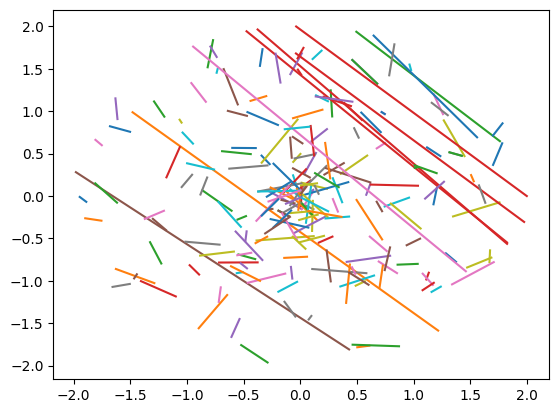

In [33]:
dataset = WrapperDataset("datasets/2/train/state_IK_random_start.csv", supervised=False)

for x, y in random.choices(dataset, k=200):
    curr_pos = x[2: 4]
    target_pos = y
    data = np.stack([curr_pos, target_pos])
    plt.plot(data[:, 0], data[:, 1])

##### Question: What is happening in the plot above?

In [47]:
model = nn.Sequential(nn.Linear(6, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
optim = Adam(model.parameters(), lr=0.0003)

In [48]:
EPOCHS = 100
train_dataset = WrapperDataset("datasets/2/train/state_IK_random_start.csv")
train_loader = DataLoader(train_dataset, 32)
val_dataset = WrapperDataset("datasets/2/val/state_IK_random_start.csv")
val_loader = DataLoader(val_dataset, 256)



def loss_fn(angles, y):
    pos = forward_kinematics(angles)[:, -1]
    return F.huber_loss(pos, y)

# loss_fn = PointDistanceLoss("cpu")

stats = defaultdict(list)


for idx in range(EPOCHS):
    train_losses = []

    for x, y in train_loader:
        angles = model(x)
        loss = loss_fn(angles, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_losses.append(loss.item())

    with torch.no_grad():
        stats["val_loss"].append(np.mean([loss_fn(model(x), y) for x, y in val_loader]))
    stats["train_loss"].append(np.mean(train_losses))

    if idx % 10 == 0:
        print("train loss: ", stats["train_loss"][-1], "val_loss: ", stats["val_loss"][-1])


train loss:  0.11321440970483489 val_loss:  0.022944175
train loss:  0.0038296734897818522 val_loss:  0.005036541
train loss:  0.0026985640678861248 val_loss:  0.0027196347
train loss:  0.002120450643388132 val_loss:  0.0018886339
train loss:  0.0018465594520023206 val_loss:  0.0015906928
train loss:  0.0016687169651346157 val_loss:  0.0014089254
train loss:  0.0015373245657484132 val_loss:  0.001381317
train loss:  0.0013934847359105159 val_loss:  0.0012025147
train loss:  0.0012976998021973433 val_loss:  0.0011130932
train loss:  0.0012775220573112106 val_loss:  0.0010792832


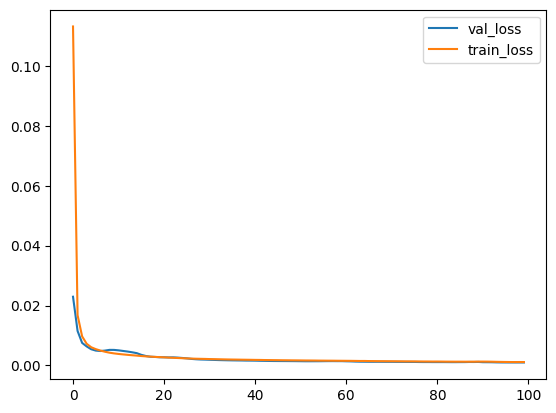

In [49]:
plt.plot(stats["val_loss"], label="val_loss")
plt.plot(stats["train_loss"], label="train_loss")
plt.legend()

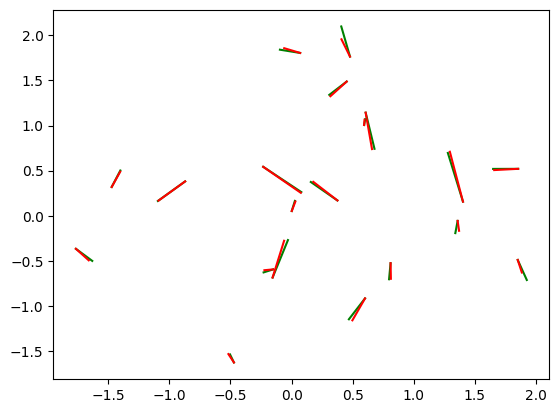

In [50]:
dataset = WrapperDataset("datasets/2/train/state_IK_random_start.csv")

for x, y in random.choices(dataset, k=20):
    with torch.no_grad():
        pred = model(x)[None, :]

    model_pos = forward_kinematics(pred)[0, -1]
    curr_pos = x[2: 4]
    target_pos = y
    data = np.stack([curr_pos, target_pos])
    data_pred = np.stack([curr_pos, model_pos])
    plt.plot(data[:, 0], data[:, 1], color="green")
    plt.plot(data_pred[:, 0], data_pred[:, 1], color="red")

### RL Env

In [74]:


def sample_pt(rng: Generator, n: int):
    phi = rng.uniform(0, 2 * np.pi)
    scale = rng.uniform(0, n)
    return np.array([scale * np.cos(phi), scale * np.sin(phi), 1])

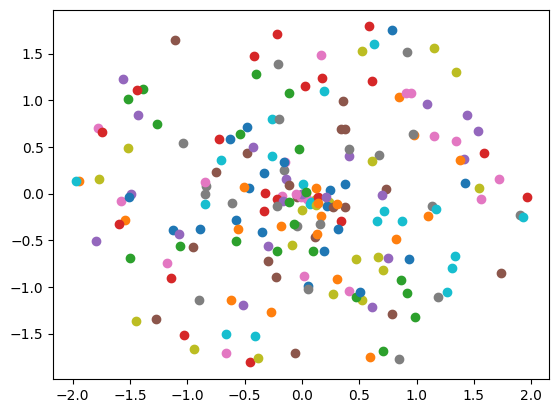

In [75]:
rng = np.random.default_rng(0)

for _ in range(200):
    plt.scatter(*sample_pt(rng, 2)[: 2])

In [206]:


# label_angles, _, _, _ = IK(
#     new_target,
#     np.rad2deg(state_angles[state_idx]).copy(),
#     np.ones_like(state_angles[state_idx]),
#     err_min=0.001)

arm = RobotArm(2)
target = sample_pt(rng, 2)
print(arm.end_position)
arm.IK(target, error_min=0.001)
print(arm.end_position)
print(target)

[2. 0.]
[ 1.38484904 -0.37103012]
[ 1.38437423 -0.3702335   1.        ]


In [207]:
class Army(gym.Env):
    def __init__(self):
        super().__init__()
        self.rng = np.random.default_rng(0)

        self.arm = RobotArm(2)
        self.target_pos = None

    def seed(self, seed: int = 0):
        self.rng = np.random.default_rng(seed)

    def obs(self):
        return np.concatenate([self.arm.positions[-1], self.arm.angles])

    def reset(self):
        start_pos = sample_pt(self.rng, self.arm.n_joints)
        arm.IK(start_pos, error_min=0.001)
        self.target_pos = sample_pt(self.rng, self.arm.n_joints)
        return self.obs()
    
    def step(self, action):
        self.arm.set(action)
        return self.obs()

    def render(self, fig=None, ax=None, color="k"):
        if fig is None or ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.set_xlim([-2.2, 2.2])
        ax.set_ylim([-2.2, 2.2])
        ax.scatter(*self.target_pos[:2])

        for p1, p2 in zip(self.arm.positions, self.arm.positions[1: ]):
            data = np.stack([p1, p2])
            ax.plot(data[:, 0], data[:, 1], color=color, marker=".", alpha=1/5)

        return fig, ax

    def direction(self, max_length=0.2):
        delta = self.target_pos[: 2] - self.arm.end_position
        norm = np.linalg.norm(delta, 2)
        scaling = 1 if norm < max_length else max_length / norm
        return scaling * delta
 